<a href="https://colab.research.google.com/github/TienNguyen0712/credit-card-fraud-detection/blob/main/notebooks/03_threshold_error_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 **Threshold And Error Analysis (Phân tích ngưỡng và sai sót)**

> Phân tích và tìm ra ngưỡng tối ưu và trả lời cho câu hỏi tại sao mô hình lại sai?

**Mục tiêu:** Nếu với 100 giao dịch xảy ra liệu có thể dự đoán hơn 80% giao dịch trong đo là gian lận hay không?
  - Với ngưỡng nào của mô hình thì đạt yêu cầu

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

## 🔍 **Threshold Analysis (Phân tích ngưỡng)**

Ở notebook trước ta đã rút ra kết luận việc sử dụng mô hình để dự đoán gian lận chính là mô hình **Logistic Regression** với **Class weight** là sự lựa chọn tối ưu vừa không tiêu tốn tài nguyên cũng như dễ canh chình

**Vấn đề**

Tuy nhiên **Recall** của mô hình đạt **0.95** nhưng **Precision** lại cực kỳ thấp **0.09**. Do đó:

- Nếu giảm ngưỡng Recall sẽ tăng nhưng Precision sẽ giàm (Báo động giả tăng)
- Nếu tăng ngưỡng Recall (Bỏ sót nhiều gian lận hơn) giảm nhưng Precision tăng (Báo động chính xác hơn)

**Phương pháp**

*Tối ưu F1*

Việc này nên sử dụng khi vừa bắt gian lận và tránh làm phiền khách hàng

$$F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision +  Recall}$$



*Theo chi phí kinh doanh*

- **Cost of FN (Bỏ sót)**: Mất bao nhiêu để vụ gian lận chót lọt
- **Cost of FP (Báo sai)**: Nất bao nhiêu để nhân viện gọi và xác nhận khách hàng



In [4]:
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")

### **Phương pháp 1: Tìm điểm tối ưu F1**

Tối ưu giữa việc bắt đúng gian lận và không báo động nhầm. Mức bao nhiêu thì mô hình hoạt động hiệu quả nhất

- Trích xuất xác suất dự đoán (Trả về xác suất - Lấy cột 2 là xấc suất của lớp gian lận)

- Quét các nhưỡng có thể (Thử nghiệm các ngưỡng từ 0 -> 1, với mỗi ngưỡng tính toán Recall và Precision)

- Tính toán F1 theo từng ngưỡng dựa vào công thức
- Tìm index mà tại đó F1 lướn nhất lưa ngưỡng vào biến tối ưu

> Tôi nên đặt mức cảnh báo bao nhiêu phần trăm để vừa bắt dược nhiều gian lận nhát vừa ít làm phiền khách hàng nhất

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     43536
           1       0.92      0.88      0.90        95

    accuracy                           1.00     43631
   macro avg       0.96      0.94      0.95     43631
weighted avg       1.00      1.00      1.00     43631



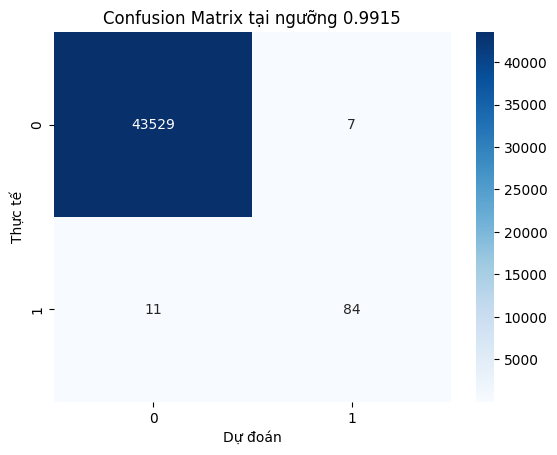

In [5]:
model_cw = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model_cw.fit(X_train, y_train)

# Trích xuất xác suất dự đoán
y_scores = model_cw.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Tìm ngưỡng giúp F1-score cao nhất
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

# Áp dụng ngưỡng mới
y_pred_final = (model_cw.predict_proba(X_test)[:, 1] >= optimal_threshold).astype(int)

print(classification_report(y_test, y_pred_final))

cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title(f'Confusion Matrix tại ngưỡng {optimal_threshold:.4f}')
plt.show()

**Nhận xét**

- **Theo ngưỡng**
  - Ngưỡng tối ưu theo F1:
    - Thay vì dùng mức 0.5, mô hình cho rằng "Chỉ khi nào xác suất gian lận trên 99.1% thì hãy phát lệnh báo động". Lọc cực nhiều báo động giả
  - Precision tại ngưỡng này:
    - Cứ 100 lần báo động thì có khoảng 92 lần là con số đúng
  - Recall tại ngưỡng này:
    - Sẽ bắt được khoảng 88.42% giao dịch gian lận thực tế
- **Theo ma trận nhầm lẫn**
  - Mô hình dự đoán đúng hoàn toàn **43529** giao dịch là không gian lận **84** giao dịch là gian lận thực sự cho tháy con số này khá cao đặc biệt dự đoán **7** giao dịch là nhầm tránh được các trường hợp gọi xấc nhận  và **11** giao dịch lọt lưới.

### **Phương pháp 2: Tìm điểm tối ưu theo KPI**

*Giả sử*: Tôi mong muốn chấp nhận nhận diện được ít nhất 83% số vụ gian lận, hãy cho tôi biết ngưỡng nhạy cảm? chấp nhận bỏ sót 17% gian lận để tối ưu

- Con số kỳ vọng theo yêu cầu kinh doanh
- Lục trong mảng recall có thể dạt được tim vị trí mà tại đó gần với con số kỳ vọng
- Thực hiện so sánh khi ấp dụng ngưỡng mới
  - Nếu xác suất gian lận >= ngưỡng mới -> 1
  - Nếu xác suất < ngưỡng mới  -> 0
> Điều khiển theo KPI. Để dạt Recall như mong muốn thì Precision tụt xuống bao nhiêu và có thể chấp nhận hay không

--- Kết quả tại ngưỡng tối ưu (1.0000) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     43536
           1       0.95      0.83      0.89        95

    accuracy                           1.00     43631
   macro avg       0.98      0.92      0.94     43631
weighted avg       1.00      1.00      1.00     43631



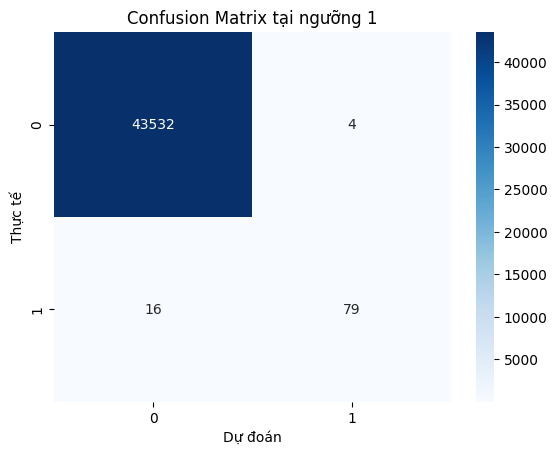

In [6]:
# Lấy xác suất dự đoán
y_scores = model_cw.predict_proba(X_test)[:, 1]

# Tìm ngưỡng tại điểm Recall mong muốn theo notebook trước (0.82)

target_recall = 0.83
idx = np.argmin(np.abs(recalls - target_recall))
best_threshold = thresholds[idx]

# Áp dụng ngưỡng mới
y_pred_new = (y_scores >= best_threshold).astype(int)

# In kết quả so sánh
print(f"--- Kết quả tại ngưỡng tối ưu ({best_threshold:.4f}) ---")

print(classification_report(y_test, y_pred_new))

cm = confusion_matrix(y_test, y_pred_new)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Confusion Matrix tại ngưỡng 1')
plt.show()

**Nhận xét**

- **Theo ngưỡng**
  - Ngưỡng tối ưu theo F1:
    - Mô hình cho rằng "Chỉ khi nào xác suất gian lận trên 89% thì hãy phát lệnh báo động". Lọc nhiều báo động giả
  - Precision tại ngưỡng này:
    - Cứ 100 lần báo động thì có khoảng 95 lần là con số đúng
  - Recall tại ngưỡng này:
    - Sẽ bắt được khoảng 83% giao dịch gian lận thực tế
- **Theo ma trận nhầm lẫn**
  - Mô hình dự đoán đúng hoàn toàn **43532** giao dịch là không gian lận **79** giao dịch là gian lận thực sự đặc biệt dự đoán **4** giao dịch là nhầm tránh được các trường hợp gọi xấc nhận và **16** giao dịch lọt lưới.

- Nếu ta chấp nhận việc bỏ qua các dự đoán gian lận mà giảm chi phí gọi khi thực hiện khóa thẻ nhầm ra cũng có thể cân nhắc lựa chọn ngưỡng

## 📏 **Feartures Importance (Đặc trưng quan trọng)**

> Đánh giá xem đặc trưng nào đóng góp trong quá trình dự đoán của model

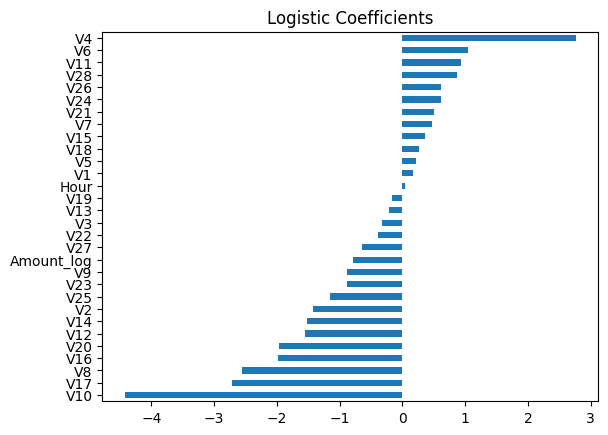

In [17]:
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

coef = model.coef_[0]

importance = pd.Series(coef, index=X_train.columns)
importance.sort_values().plot(kind='barh')
plt.title("Logistic Coefficients")
plt.show()

**Nhận xét**

## 🚨 **Error Analysis (Phân tích lỗi)**